#  Exploring Underrated Cinema Across Time and Place          

Index-ception: Aniket Gauba, Fatima Abbas, Tri Dang, Amaya Joshi


## Introduction

Over one particularly long summer, one team-member of Index-ception thought that the movie Napolean Dynamite was the best underrated movie that they had ever seen. This was until they were informed that most people consider the movie to be 'criminally overrated', that it had 234,000 IMDB votes, and 23 award nominations. The team-member then realised that their understanding of underrated movies was perhaps skewed, and they wanted to develop a taste for movies beyond just what was trending on Netflix. As a result, the entire Index-ception team decided to come together and build lists of some of the most truly underrated movies across genres, decades, regions, and languages. 

### Ethical Considerations
The Internet Movie Database (IMDB) itself is not subject to copyright due to this information being readily available and easily accessible on the internet. The IMDB provides a condensed and organized summary of many shows and movies for commercial and personal usages. Furthermore, the IMDB is available for free use on the internet. However, the IMDB and its users are still subject to fair use. This includes ensuring that we accurately represent the data and our results. We must aim to not remove any valid data points that may speak to our results, or represent any movie as something that it is not. We also aim for our results to not show bias towards any movie, especially its cast or crew members. We will also cite all outside sources that we used to aid us in this project. 


### Database Design 

The database that we used for this project was the complete IMDB database that contained four tables: title_basics, title_akas, ratings, and genres. Since our project revolves around finding underrated movies across multiple categories, we needed to choose columns from every table to do our analysis. These types will help differentiate movies for personal preferences and data analysis. Therefore, we decided to create a fifth table that combined specific columns from these tables into a single table. We achieved this by left joining genres, ratings, and title_akas on title_basics, but only picking the relevant columns from each table (averageRating, numVotes, region, language, genre):

In [25]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("data/imdb_full.db")
c = conn.cursor()


query = "SELECT tb.titleId,tb.titleType,tb.primaryTitle,tb.originalTitle,tb.isAdult,tb.startYear,tb.endYear,tb.runtimeMinutes,r.averageRating,r.numVotes, ta.region,ta.language,g.genre FROM title_basics AS tb JOIN genres AS g ON tb.titleId = g.titleId JOIN ratings AS r ON tb.titleId = r.titleId JOIN title_akas AS ta ON tb.titleId = ta.titleId"


c.execute(query)


results = c.fetchall()

columns = ['titleId', 'titleType','primaryTitle', "originalTitle", "isAdult", "startyear", "endYear", 'runtimeMinutes', "averageRating","numVotes","region","language","genre"]


df = pd.DataFrame(results, columns=columns)
df.to_sql('joined_table', conn, if_exists='replace', index=False)
df


,titleId,titleType,primaryTitle,originalTitle,isAdult,startyear,endYear,runtimeMinutes,averageRating,numVotes,region,language,genre
0,tt11490594,tvEpisode,I Am the Only President and Kamen Rider,I Am the Only President and Kamen Rider,0,2020.0,NaN,None,7.9,16,JP,None,Action
1,tt11490594,tvEpisode,I Am the Only President and Kamen Rider,I Am the Only President and Kamen Rider,0,2020.0,NaN,None,7.9,16,JP,None,Adventure
2,tt11490594,tvEpisode,I Am the Only President and Kamen Rider,I Am the Only President and Kamen Rider,0,2020.0,NaN,None,7.9,16,JP,None,Comedy
3,tt11490602,short,Saïda,Saïda,0,2013.0,NaN,7,7.8,8,TN,None,Documentary
4,tt11490602,short,Saïda,Saïda,0,2013.0,NaN,7,7.8,8,TN,None,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9494550,tt8995696,short,Rooting for Roona,Rooting for Roona,0,2020.0,NaN,40,7.0,485,DE,None,Short
9494551,tt8995696,short,Rooting for Roona,Rooting for Roona,0,2020.0,NaN,40,7.0,485,FR,None,Short
9494552,tt8995696,short,Rooting for Roona,Rooting for Roona,0,2020.0,NaN,40,7.0,485,GR,None,Short
9494553,tt8995696,short,Rooting for Roona,Rooting for Roona,0,2020.0,NaN,40,7.0,485,HU,None,Short


## Data Exploration        

According to the Oxford English Dictionary (OED), the word underrated is defined as "Rated or valued too low." According to Merriam-Webster, on the other hand, the term is defined to be describing something that is "Not recognized for its true worth; undervalued." These definitions, when analyzed in the context of movies, could be interpreted to mean two different things: while the OED definition could be interpreted to describe a movie that is rated lower than it deserves, Merriam-Webster's definition could be taken to refer to movies that are simply not recognised or known by a large enough group of people. While a single meaning for the term underrated is difficult to determine for movies, for this project, we singled out Merriam-Webster's definition, and used tools in data analytics to create lists of underrated movies across genres, regions, and decades. Using this definition and applying it to movies meant that we were looking for movies that were underrecognised in terms of number of votes, but ranked well within the votes that they had. Our main challenge, then, was to determine what it means for a movie to have low enough votes and high enough ratings to be 'underrated', and so our first step for this project was to use some basic statistical tools to determine a number for 'good' rating and 'low' votes. 

To achieve this, we first looked at the median number of votes (so the result would not be skewed by movies like Shawshank Redemption!) and mean number of ratings (since ratings are on a fixed scale from 0-10, there is no concern about outliers here) across movies in the IMDB datase: 

In [30]:
avgRating = 'SELECT AVG(averageRating) AS average_rating FROM joined_table'

avgRating = c.execute(avgRating).fetchone()
print(f" Average Rating: {avgRating[0]}")

 Average Rating: 6.599971741698268


In [31]:
median_votes = """
WITH orderedvotes AS (
    SELECT 
        numVotes,
        ROW_NUMBER() OVER (ORDER BY numVotes) AS row_num
    FROM 
        joined_table
),
Countedvotes AS (
    SELECT COUNT(*) AS total_count FROM orderedvotes
)
SELECT AVG(numVotes) AS median
FROM orderedvotes
WHERE row_num IN (
    (SELECT CAST((total_count + 1) / 2 AS INTEGER) FROM Countedvotes),
    (SELECT CAST((total_count + 2) / 2 AS INTEGER) FROM Countedvotes)
);
"""

median_rating = c.execute(median_votes).fetchone()
print(f"Median Votes: {median_rating[0]}")

Median Votes: 230.0


From executing these queries, we see that the average ratings of movies in IMDB are about 6.5, whereas the median number of votes is 230. Based on these results, we want to pick a rating slightly higher than the average rating, and according to the IMDB FAQ, an average-good rating for a movie is about a score of 7, whereas good-excellent is a score of 8 or more. Thus, in our definition of underrated, we defined a good rating to mean any rating over 7.5. As for deciding an upper-limit for vote count, we felt that using the median vote number of 230 was too low for our purposes, and so we browsed multiple websites and discussion posts (Reddit, Quora, Buzzfeed, and IMDB) and learned that many people would define an underrated movie to have anywhere from 100-25,000 votes. While this range is quite expansive, we noticed that many film festivals that feature underrated movies (Lonely Seal, Locarno, Austin Film Festival, etc.) tend to only feature movies with less than 10,000 votes, and so we decided to define an underrated movie for the context of this analysis to be any that has below 10,000 votes for an average rating of over 7.5.  

Given this, we first looked at top 10 underrated movies across all categories. The way in which we intended for our code to order the results was so that it would order the number of votes in descending order first, and then order the average rating in descending order. The reason we approached it this way throughout our project was so that we wouldn't have any movies with 50 or fewer votes, but incredibly high ratings on our lists, as that would not introduce nearly enough opinions for a reliable rating.

In [34]:
#Top ten underrated movies across all categories 
top_ten_underrated = c.execute('''
    SELECT numVotes, averageRating, primaryTitle, region
    FROM joined_table
    WHERE numVotes < 10000 AND averageRating > 7.5 GROUP BY primaryTitle
    ORDER BY numVotes DESC, averageRating DESC
    LIMIT 10
''').fetchall()
columns=['numVotes', 'averageRating', 'PrimaryTitle', 'Region']
pd.DataFrame(top_ten_underrated, columns=columns)

,numVotes,averageRating,PrimaryTitle,Region
0,9997,9.0,Harga,None
1,9993,9.1,A Cold Day in Hell's Kitchen,US
2,9990,7.9,Salaam Bombay!,None
3,9989,8.0,Drops of God,None
4,9987,7.7,Childrick of Mort,US
5,9983,8.1,Steven Sees a Ghost,US
6,9981,7.7,When Father Was Away on Business,None
7,9980,8.2,Bommarillu,None
8,9977,8.3,Maheshinte Prathikaaram,None
9,9973,7.8,The Classic,None


From this result, we see that Harga is top across all categories for most underrated by our definition. We also see many other international movies like Salaam Bombay! or Bommarillu in this list (most international movies in this database tend to have a label of None for region). This result makes sense because international movies can not be expected to have a high vote count within a primarily American voter base. However, if we were to consider this project to only be looking at underrated movies by and for the perspective of an American audience, then this list of movies is absolutely applicable. 

Next, our aim was to create a list of most underrated movies by genre: 

In [36]:
top_genre = c.execute('''
    WITH ranked AS (
        SELECT 
            numVotes, 
            averageRating, 
            primaryTitle, 
            genre,
            ROW_NUMBER() OVER (PARTITION BY genre ORDER BY numVotes DESC, averageRating DESC) AS number
        FROM joined_table
        WHERE numVotes < 10000 AND averageRating > 7.5
    )
    SELECT 
        numVotes, 
        averageRating, 
        primaryTitle, 
        genre
    FROM ranked
    WHERE number = 1
    ORDER BY genre
''').fetchall()

columns = ['numVotes', 'averageRating', 'PrimaryTitle', 'genre']
pd.DataFrame(top_genre, columns=columns)


,numVotes,averageRating,PrimaryTitle,genre
0,9993,9.1,A Cold Day in Hell's Kitchen,Action
1,701,9.3,Axel in Harlem,Adult
2,9987,7.7,Childrick of Mort,Adventure
3,9987,7.7,Childrick of Mort,Animation
4,9825,8.1,Requiem for the American Dream,Biography
5,9987,7.7,Childrick of Mort,Comedy
6,9993,9.1,A Cold Day in Hell's Kitchen,Crime
7,9912,7.9,Bob Dylan: Dont Look Back,Documentary
8,9997,9.0,Harga,Drama
9,9895,8.4,The Adventures of Pete & Pete,Family


The results of this table show the top most underrated movie for each identified genre in the database. From this, we do see movies like 'A Cold Day in Hell's Kitchen' multiple times because they have multiple identified genres. Next, we moved on the exploring top most underrated movies by Region: 

In [38]:
#top ten
top_ten_region = c.execute('''
    WITH ranked AS (
        SELECT 
            numVotes, 
            averageRating, 
            primaryTitle, 
            region,
            ROW_NUMBER() OVER (PARTITION BY region ORDER BY numVotes DESC, averageRating DESC) AS number
        FROM joined_table
        WHERE numVotes < 10000 AND averageRating > 7.5
    )
    SELECT 
        numVotes, 
        averageRating, 
        primaryTitle, 
        region
    FROM ranked
    WHERE number = 1
    GROUP BY primaryTitle
    ORDER BY region
''').fetchall()

columns = ['numVotes', 'averageRating', 'PrimaryTitle', 'region']
df = pd.DataFrame(top_ten_region, columns=columns)
df


,numVotes,averageRating,PrimaryTitle,region
0,9997,9.0,Harga,None
1,51,8.1,Impacto,AD
2,6772,9.0,The Other Me,AF
3,29,8.4,Vanishing Sail,AG
4,7306,7.7,Sailor Moon,AL
...,...,...,...,...
137,9368,8.4,Infinity Train,XSA
138,1183,7.9,10 Days Before the Wedding,YE
139,9965,8.3,Frozen Stiff,YUCS
140,17,9.4,Mpali,ZM


Unfortunately, these results were a little harder to interpret simply because there are multiple movies within our database that are classified as having region 'None'. In addition to that, according to the IMDB website, IMDB classifies region in two ways: (1) "the country of a title as the place or places where the production companies for that title are based, and therefore where the financing originated" (2) "If a title is a multi-country production, the order the countries are entered into the addition/update forms is significant and will be reflected in the display order within IMDb". However, since there is wide user-contribution to IMDB, most users are free to define the region of origin for a movie as they please. As a result, a single movie in the database can have multiple regions, meaning that these results do not necessarily represent the true country of origin for that movie. Regardless, this list is still insightful. We see that Impacto is the most underrated movie from Andorra, while (comedically) N00bslayr is the most underrated from Zambia.

After this, we moved on to creating a list of underrated movies by the decades: 

In [40]:
decades = range(1890, 2030, 10)
decade_dfs = {}
for decade in decades:
    query = f"""
    SELECT 
        primaryTitle,
        averageRating,
        numVotes,
        startYear
    FROM joined_table
    WHERE 
        startYear >= {decade} AND startYear < {decade + 10} AND
        numVotes < 10000 AND 
        averageRating > 7.5
    GROUP BY primaryTitle
    ORDER BY numVotes DESC, averageRating DESC
    LIMIT 10;
    """
    results = c.execute(query).fetchall()
    
    columns = ['Primary Title', 'Average Rating', 'Number of Votes', 'Start Year']
    decade_dfs[decade] = pd.DataFrame(results, columns=columns)

for decade, df in decade_dfs.items():
    display(HTML(f"<h3>Top Movies of the {decade}s</h3>"))
    display(df.style.set_table_attributes("style='display:inline'").set_caption(f"Decade: {decade}s"))




,Primary Title,Average Rating,Number of Votes,Start Year


,Primary Title,Average Rating,Number of Votes,Start Year
0,Foxy Grandpa Shows the Boys a Trick or Two with the Tramp,8.200000,86,1902.000000
1,The Laughing Nigger,8.300000,79,1907.000000
2,Another Picture Showing Demonstration of a Pneumatic Shell Riveter,8.500000,54,1900.000000
3,"Demonstrating the Action of the Brown Hoisting and Conveying Machine in Unloading a Schooner of Iron Ore, and Loading the Material on the Cars",8.300000,43,1900.000000
4,The Bicycle Thief,8.000000,43,1904.000000
5,Halloween,8.500000,40,1905.000000
6,We Must Do Our Best,8.200000,38,1909.000000
7,From London to Brighton,7.700000,37,1903.000000
8,All Coons Look Alike to Me (Parody),8.000000,35,1908.000000
9,Demonstrating the Operation of the Harrington Rail Bonding System on the Line of the Coney Island and Brooklyn Railroad Co.,8.200000,31,1900.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,A Dog's Life,7.700000,9469,1918.000000
1,The Immigrant,7.600000,9057,1917.000000
2,The Cameraman's Revenge,7.700000,3150,1912.000000
3,J'accuse!,7.700000,2006,1919.000000
4,Ayastefanos'taki Rus Abidesinin Yikilisi,8.200000,272,1914.000000
5,A Trip to the Moon,7.900000,188,1914.000000
6,Cecilia of the Pink Roses,8.500000,120,1918.000000
7,On Dangerous Ground,8.500000,120,1917.000000
8,Tom and Jerry,7.800000,114,1911.000000
9,Barrabas,7.600000,110,1919.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,"Dr. Mabuse, the Gambler",7.800000,9064,1922.000000
1,One Week,8.100000,9044,1920.000000
2,The Crowd,8.100000,8987,1928.000000
3,The Unknown,7.700000,8891,1927.000000
4,Napoleon,8.200000,8608,1927.000000
5,Strike,7.600000,8500,1925.000000
6,Ben-Hur: A Tale of the Christ,7.800000,7896,1925.000000
7,The Man Who Laughs,7.600000,7844,1928.000000
8,The Big Parade,7.900000,7166,1925.000000
9,The Wind,8.000000,7035,1928.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,Dodsworth,7.800000,9969,1936.000000
1,Port of Shadows,7.700000,9832,1938.000000
2,Make Way for Tomorrow,8.200000,9341,1937.000000
3,Gold Diggers of 1933,7.700000,9024,1933.000000
4,Stage Door,7.700000,8921,1937.000000
5,Way Out West,7.600000,8892,1937.000000
6,Libeled Lady,7.800000,8759,1936.000000
7,Le Jour Se Leve,7.700000,8177,1939.000000
8,Pépé le Moko,7.700000,7963,1937.000000
9,The Music Box,7.900000,7940,1932.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,The Set-Up,7.800000,9916,1949.000000
1,The Fallen Idol,7.600000,9485,1948.000000
2,The Big Clock,7.600000,9384,1948.000000
3,Paisan,7.600000,9383,1946.000000
4,The Snake Pit,7.600000,8301,1948.000000
5,A Tree Grows in Brooklyn,8.000000,8300,1945.000000
6,Random Harvest,7.900000,8288,1942.000000
7,Obsession,7.600000,8165,1943.000000
8,Shoeshine,8.000000,8010,1946.000000
9,The Miracle of Morgan's Creek,7.600000,7886,1943.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,Where the Sidewalk Ends,7.600000,9784,1950.000000
1,Mother India,7.800000,9772,1957.000000
2,Early Summer,8.100000,9390,1951.000000
3,Duck Amuck,8.600000,9305,1953.000000
4,Leave It to Beaver,7.600000,9146,1957.000000
5,The Human Condition I: No Greater Love,8.500000,9125,1959.000000
6,White Nights,7.800000,8864,1957.000000
7,Floating Weeds,7.900000,8770,1959.000000
8,Hobson's Choice,7.700000,8602,1954.000000
9,The Bridge,8.000000,8520,1959.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,Chimes at Midnight,7.600000,9969,1965.000000
1,Bob Dylan: Dont Look Back,7.900000,9912,1967.000000
2,The Prime of Miss Jean Brodie,7.600000,9744,1969.000000
3,Lonely Are the Brave,7.600000,9665,1962.000000
4,The Shop on Main Street,8.200000,9572,1965.000000
5,Mister Rogers' Neighborhood,8.700000,9407,1968.000000
6,A Raisin in the Sun,8.000000,9351,1961.000000
7,A Patch of Blue,8.000000,9340,1965.000000
8,The Outer Limits,8.200000,9139,1963.000000
9,Happiness,7.600000,9043,1965.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,The New Tom & Jerry Show,7.800000,9953,1975.000000
1,The Mary Tyler Moore Show,8.300000,9950,1970.000000
2,The Ascent,8.200000,9833,1977.000000
3,Pink Floyd: Live at Pompeii,8.600000,9570,1972.000000
4,The Blue Bead,7.800000,9565,1975.000000
5,Mind Your Language,8.700000,9515,1977.000000
6,Tinker Tailor Soldier Spy,8.500000,9436,1979.000000
7,Love in the Afternoon,7.600000,9165,1972.000000
8,Are You Being Served?,8.000000,9035,1972.000000
9,"Ugly, Dirty and Bad",7.700000,8996,1976.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,Salaam Bombay!,7.900000,9990,1988.000000
1,When Father Was Away on Business,7.700000,9981,1985.000000
2,The Thorn Birds,7.900000,9933,1983.000000
3,A Bit of Fry and Laurie,8.300000,9848,1987.000000
4,Landscape in the Mist,7.900000,9441,1988.000000
5,The Taming of the Scoundrel,7.600000,9377,1980.000000
6,Davaro: Son Eskiya,8.100000,9215,1981.000000
7,V: The Final Battle,7.700000,9172,1984.000000
8,Barefoot Gen,8.000000,9011,1983.000000
9,Pixote,7.900000,8994,1980.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,The One Where Monica Gets a Roommate,8.100000,9969,1994.000000
1,The Adventures of Pete & Pete,8.400000,9895,1992.000000
2,The Batman Superman Movie: World's Finest,7.700000,9875,1997.000000
3,Spawn,8.100000,9802,1997.000000
4,A Summer's Tale,7.600000,9722,1996.000000
5,Through the Olive Trees,7.700000,9707,1994.000000
6,Mulholland Dr.,8.200000,9650,1999.000000
7,WWE Raw,7.700000,9614,1993.000000
8,Butterfly,7.600000,9604,1999.000000
9,Train of Life,7.600000,9535,1998.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,Bommarillu,8.200000,9980,2006.000000
1,The Classic,7.800000,9973,2003.000000
2,Frozen Stiff,8.300000,9965,2002.000000
3,CMYLMZ,9.200000,9906,2008.000000
4,The Making of 'Kill Bill',7.700000,9902,2003.000000
5,The First Day of the Rest of Your Life,7.600000,9880,2008.000000
6,Kenny vs. Spenny,8.100000,9860,2002.000000
7,Diversity Day,8.100000,9825,2005.000000
8,Tupac: Resurrection,7.900000,9767,2003.000000
9,The Family of Blood,9.200000,9735,2007.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,A Cold Day in Hell's Kitchen,9.100000,9993,2016.000000
1,Steven Sees a Ghost,8.100000,9983,2018.000000
2,Maheshinte Prathikaaram,8.300000,9977,2016.000000
3,Rita,8.100000,9943,2012.000000
4,The Ones We Leave Behind,8.600000,9913,2015.000000
5,Assassin's Creed: Origins,8.400000,9879,2017.000000
6,Resident Evil VII: Biohazard,8.600000,9870,2017.000000
7,eps1.6_v1ew-s0urce.flv,8.400000,9858,2015.000000
8,A Sun,7.600000,9858,2019.000000
9,A God Walks into Abar,9.400000,9846,2019.000000


,Primary Title,Average Rating,Number of Votes,Start Year
0,Harga,9.000000,9997,2021.000000
1,Drops of God,8.000000,9989,2023.000000
2,Childrick of Mort,7.700000,9987,2020.000000
3,Middle Game,8.400000,9967,2020.000000
4,Walk with Us,9.000000,9962,2020.000000
5,"Shibuya Incident - Gate, Open",9.700000,9912,2023.000000
6,Nonstandard,9.600000,9899,2021.000000
7,"Saas, Bahu Aur Flamingo",7.700000,9871,2023.000000
8,24/7,8.400000,9856,2022.000000
9,Roadrunner: A Film About Anthony Bourdain,7.700000,9821,2021.000000


By running the above code chunk, we have identified the **top 10 underrated movies** for each decade, starting from the **1890s to 2020s**. The dataset includes movie information up to the year **2024**, providing a comprehensive view of underrated cinematic gems across decades.

##### Key Insights:
- The analysis spans over **13 decades**, showcasing the evolving trends in filmmaking and audience preferences.

##### Decade-wise Highlights:
Below are the standout top underrated movie for each decade:

1890s
This decade had no movies that fulfilled our 'underrated' criteria.

1900s
Foxy Grandpa Shows the Boys a Trick or Two with the Tramp 

1910s
A Dog's Life

1920s
Dr. Mabuse, the Gambler	

1930s
Dodsworth

1940s
The Set-Up	

1950s
Where the Sidewalk Ends

1960s
Chimes at Midnight

1970s
The New Tom & Jerry Show

1980s
Salaam Bombay!	

1990s
The One Where Monica Gets a Roommate	

2000s
Bommarillu	

2010s
A Cold Day in Hell's Kitchen	

2020s
Harga

##### Concluding Observations:
- The **underrated masterpieces** identified in this analysis provide a rich reservoir for cinephiles seeking hidden gems across time periods.
- Future work could involve exploring trends in why these movies remained underrated during their respective eras and how they have been rediscovered over time.

After this, we moved on to creating a list of underrated movies by the language:

In [42]:
language_df = pd.read_csv('data/iso-language-codes.csv')

top_language = c.execute('''
    WITH ranked AS (
        SELECT 
            numVotes, 
            averageRating, 
            primaryTitle, 
            language,
            ROW_NUMBER() OVER (PARTITION BY language ORDER BY numVotes DESC, averageRating DESC) AS number
        FROM joined_table
        WHERE numVotes < 10000 AND averageRating > 7.5
    )
    SELECT 
        numVotes, 
        averageRating, 
        primaryTitle, 
        language AS alpha2
    FROM ranked
    GROUP BY alpha2
''').fetchall()

columns = ['numVotes', 'averageRating', 'PrimaryTitle', 'alpha2']
top_language_df = pd.DataFrame(top_language, columns=columns)
merged_df = top_language_df.merge(language_df, on="alpha2")
merged_df = merged_df.rename(columns={'English': 'Language'})
merged_df = merged_df.drop("alpha2", axis=1)
merged_df



,numVotes,averageRating,PrimaryTitle,Language
0,7898,8.0,Price of Passion,Afrikaans
1,9997,9.0,Harga,Arabic
2,705,8.4,Qaynana,Azerbaijani
3,9990,7.9,Salaam Bombay!,Bulgarian
4,9990,7.9,Salaam Bombay!,Bengali
...,...,...,...,...
62,9557,8.3,In the Name of God,Urdu
63,93,8.8,The Mischievous Boy,Uzbek
64,8,9.5,Orango,Wolof
65,49,8.8,Plane Crash,Yiddish


The analysis of underrated movies by language leverages a robust SQL query and a merged dataset of ISO language codes to identify top-rated films for each language. This approach provides valuable insights into the linguistic diversity of underrated movies, despite the challenges posed by the dataset's complexity. But analysis presented some challenges due to the complexity and diversity of the dataset. In our database, there are 66 unique languages, which makes it difficult to thoroughly interpret and review results for every language. Additionally, some of these languages might not be familiar or easily recognizable, further complicating the task of drawing meaningful conclusions for each one.

Despite these challenges, the analysis provides interesting insights. For example, we identified that Salaam Bombay! is the most underrated film in Bengali, while Harga holds that title in Arabic. These results highlight the global reach of cinema and how movies in lesser-known languages can still garner high ratings despite lower recognition or vote counts.

It is worth noting that IMDb allows for user contributions to language classification, which can sometimes result in inconsistencies. A single movie might be associated with multiple languages, or its primary language may not be accurately represented. Despite these limitations, this analysis offers a fascinating glimpse into the linguistic diversity of underrated movies and underscores the importance of considering global perspectives in cinematic evaluation.

## Visualizing the Data

To gain deeper insights and analyze patterns, we now visualize the data. Visualization allows us to uncover trends, and relationships that might not be immediately evident in raw data. We will examine the **distribution of underrated movies based on region, decades and language**. This helps us understand how different cultures and linguistic groups contribute to the pool of underrated cinematic gems. These visualizations will provide a comprehensive overview of the trends and diversity in underrated movies.

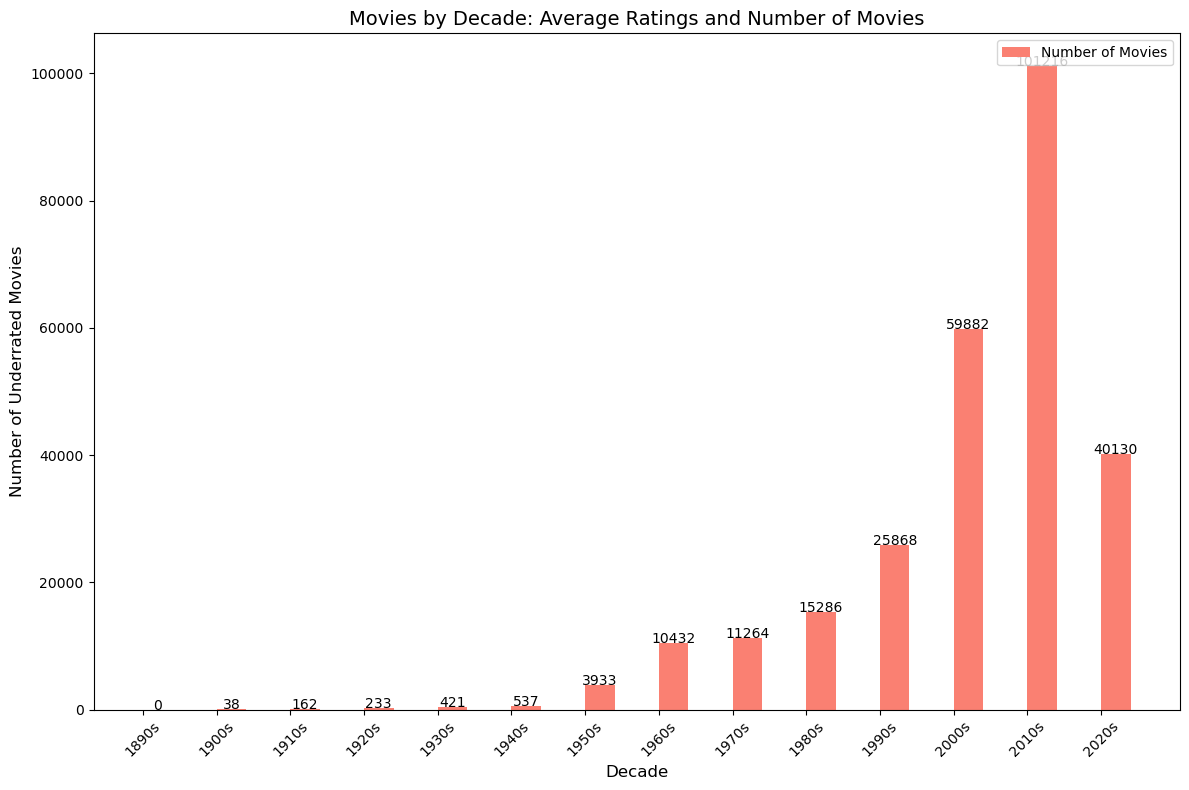

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
import pandas as pd

decades = range(1890, 2030, 10)
decade_dfs = {}
for decade in decades:
    query = f"""
    SELECT 
        primaryTitle,
        averageRating,
        numVotes,
        startYear
    FROM joined_table
    WHERE 
        startYear >= {decade} AND startYear < {decade + 10} AND
        numVotes < 10000 AND 
        averageRating > 7.5
    GROUP BY primaryTitle
    ORDER BY numVotes DESC, averageRating DESC;
    """
    results = c.execute(query).fetchall()
    columns = ['Primary Title', 'Average Rating', 'Number of Votes', 'Start Year']
    decade_dfs[decade] = pd.DataFrame(results, columns=columns)

# Bar Plot 
decades_list = []
movie_counts = []

for decade, df in decade_dfs.items():
    decades_list.append(decade)
    movie_counts.append(len(df))
    
x = np.arange(len(decades_list)) 
width = 0.4  
fig, ax = plt.subplots(figsize=(12, 8))
bar2 = ax.bar(x + width / 2, movie_counts, width, label='Number of Movies', color='salmon')

ax.set_xlabel('Decade', fontsize=12)
ax.set_ylabel('Number of Underrated Movies', fontsize=12)
ax.set_title('Movies by Decade: Average Ratings and Number of Movies', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f"{decade}s" for decade in decades_list], rotation=45)
ax.legend()

for bar in bar2:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1,
            f'{int(bar.get_height())}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


The bar plot reveals a **clear upward trend** in the number of underrated movies per decade. 

#### Possible Reasons for the Trend:
1. **Booming Film Industry**: The global film industry has seen exponential growth over the years. Advances in technology, globalization, and the rise of new production hubs have enabled the creation of more movies than ever before.
2. **Increased Viewership Options**: The advent of streaming platforms and digital content has expanded the variety of movies available to viewers. With more options, several high-quality movies may go unnoticed or undervalued, leading to a higher count of underrated movies.
3. **Changing Audience Preferences**: Modern audiences have diverse tastes, and niche genres or unconventional storytelling might appeal to more audiences now, contributing to the perception of "underrated" movies.

#### Specific Insights for the 2020s:
- Although we only have data up to **2024**, the number of underrated movies in the 2020s is already at **40% of the total number** observed in the 2010s. This remarkable growth within just a few years underscores the ongoing expansion of the film industry and the rise in movie production.If the current pace continues, the 2020s may witness a record number of underrated movies.


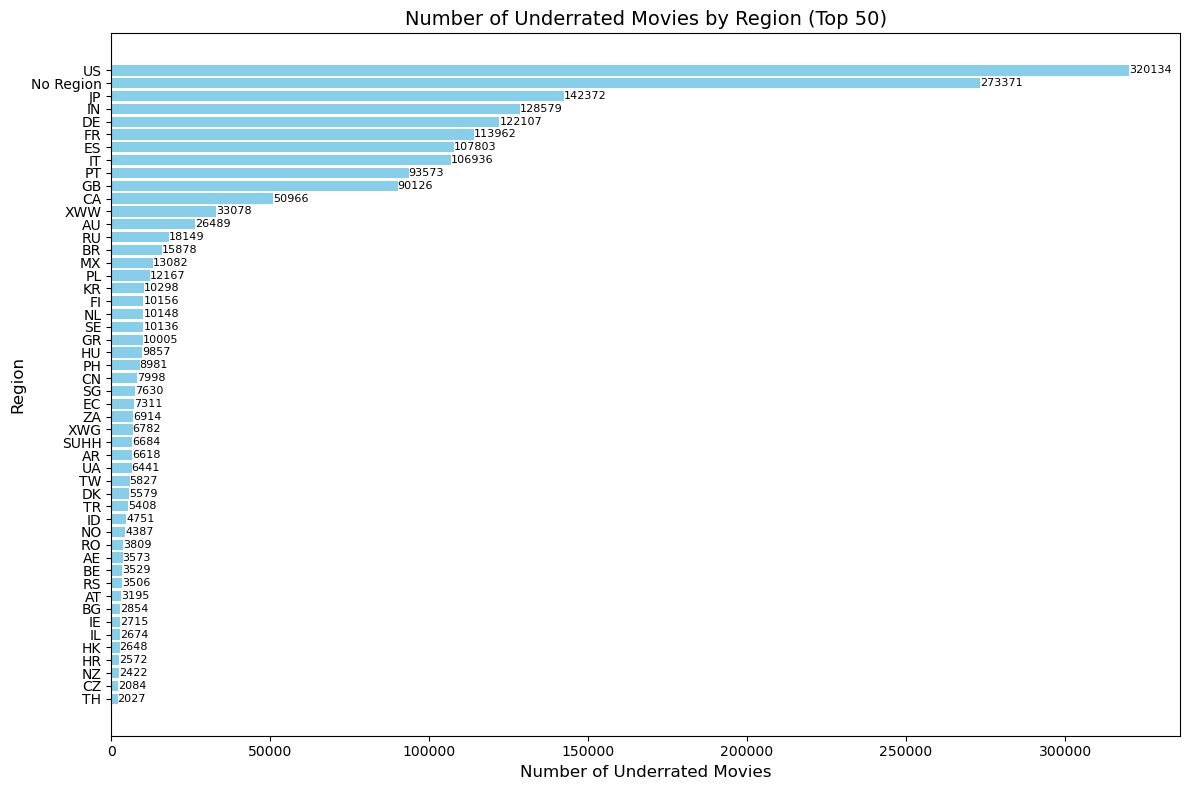

In [50]:
import matplotlib.pyplot as mpl

countQuery = """
SELECT region, COUNT(*) as showCount 
FROM joined_table 
WHERE (numVotes < 10000) AND (averageRating > 7.5) 
GROUP BY region 
ORDER BY showCount DESC 
LIMIT 50
"""
counter = c.execute(countQuery).fetchall()
countDf = pd.DataFrame(counter, columns=['Region', 'Number of Underrated Movies'])
countDf['Region'] = countDf['Region'].fillna('No Region')
countDf = countDf.sort_values(by='Number of Underrated Movies', ascending=True)
mpl.figure(figsize=(12, 8))
bars = mpl.barh(countDf['Region'], countDf['Number of Underrated Movies'], color='skyblue')

for bar in bars:
    mpl.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
             f'{int(bar.get_width())}', va='center', fontsize=8)

mpl.xlabel("Number of Underrated Movies", fontsize=12)
mpl.ylabel("Region", fontsize=12)
mpl.title("Number of Underrated Movies by Region (Top 50)", fontsize=14)

mpl.tight_layout()  
mpl.show()


The US, by no surprises, makes the top for underrated movies. Being the region where movies and shows are seen by almost everyone. With major cultural diversities in the United States and most importantly, the US is one of the easiest countries to have arts and works published without censorship or restrictions. The No Region category having the 2nd highest is probably due to its ambiguous nature. “No regions” could actually mean “all region” since it does not belong to any region, but is shafted into an extremely broad category. Japan comes a bit off a surprise. Could it be anime? Or because it is the most popular Asian country? Japan used to be a sheltered country so to strike 3rd on the chart is a major surprise. Overall, the bar graph seems to show a high deviation after a certain amount. For example, the US has far too many underrated movies compared to any other regions, but other regions also have far less underrated movies around a certain region on the bar graph.

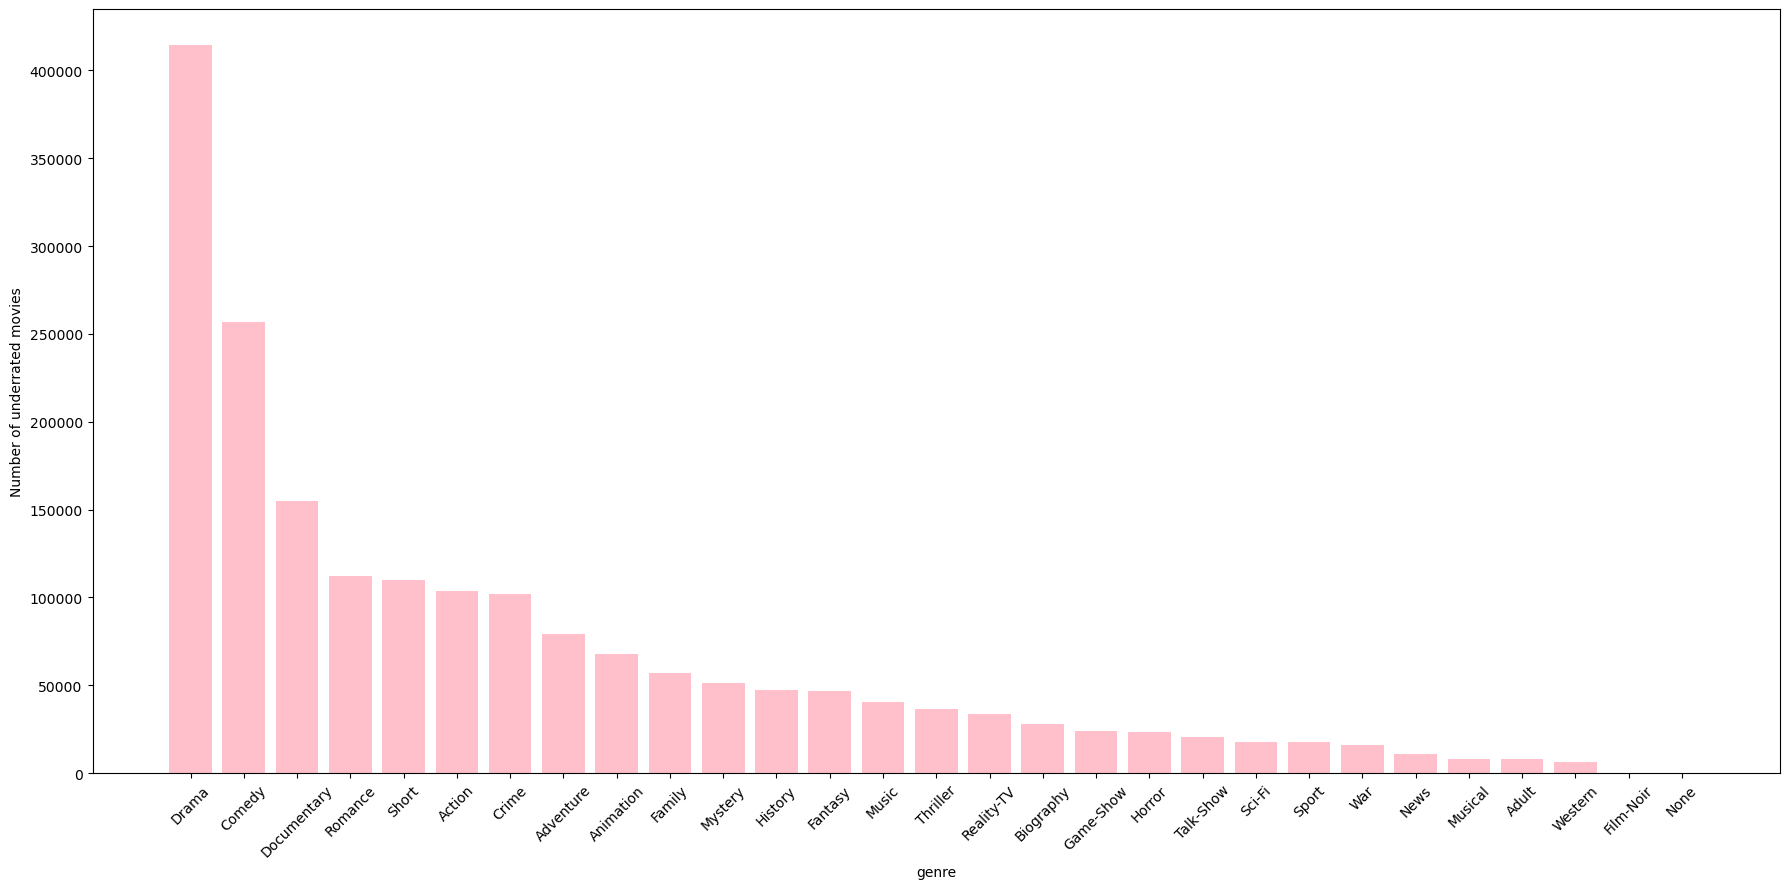

In [52]:
import matplotlib.pyplot as mpl

countQuery = f"SELECT genre, COUNT(*) as showCount FROM joined_table WHERE (numVotes < 10000) AND (averageRating > 7.5) GROUP BY genre ORDER BY showCount DESC"
counter = c.execute(countQuery).fetchall()
countDf = pd.DataFrame(counter, columns=['genre','Number of underrated movies'])
countDf

mpl.figure(figsize=(18, 9))
mpl.bar(countDf['genre'], countDf['Number of underrated movies'], color="pink")
mpl.xlabel("genre")
mpl.ylabel("Number of underrated movies")
mpl.xticks(rotation=45) 


mpl.tight_layout() 
mpl.show()


Graph above is sorted in descending order. Similarly to regions, the number of underrated movies has a high deviation where Drama exceeds comedy and comedy exceeds anything before it. This trend seems to calm down after “documentary” where the other genres’ amount of underrated movies seem to be comparable with other genres. Recalling back to where underrated movies does not have a region, it could mean these genres on the graph do not reside in any region. Without a proper region, it could lack the exposure it needs to be successful. Interestingly, there are no underrated film-noir movies. According to google, film-noir movies were made from 1944 to 1954. Looking at the graph with decades, it seems that movies started to become relevant during the 1940th to 1950th decade. There are a few possibilities with this. For one, there could’ve been much attraction and hype around movies where everybody binge-watched everything. Another could be that the limited amount of movies meant that film-noir movies were able to stand out more. Or finally, film-noir could be the root cause of the attraction hype in the 1940s and 50s. Unlike region, it seems that all movies were able to have a genre attached to them. This is evident with the “None” genre having no underrated movies.  


## Uses of Python: Technical Components

_Fill in the table below with information about how you satisfied the technical requirements of the assignment._ 
    
| Component | Usage | Explanation | 
|:---|:---|:---|
| _leave this column as-is_ | _name the method(s)/ function(s) you used_ | _Use this area to explain what you were trying to achieve with this particular use of code and to describe why you chose to use this particular method or approach_ | 
| complex SQL query 1 | c.execute()| used to execute SQL queries, such as retrieving, joining, filtering, grouping, and ranking data from the SQLite database |
| complex SQL query 2| c.fetchall()| used to retrieve all the rows from the result set of the SQL queries executed with c.execute, converting the query output into a format that can be processed and analyzed in Python.| 
| complex SQL query 3 | c.fetchone| used to retrieve a single row from the result set of an executed SQL query, specifically for fetching the result of the average rating calculation.| 
| table join | JOIN| used in SQL queries to combine data from multiple related tables (title_basics, genres, ratings, and title_akas) based on their shared titleId| 
| GROUP BY clause | GROUP BY| used in SQL queries to aggregate data by specific columns, such as primaryTitle, genre, region, or language, allowing the analysis of top-underrated movies within each group and summarizing the data effectively for comparisons.| 
| WHERE clause | WHERE| used in SQL queries to filter data based on specific conditions, such as selecting movies with numVotes < 10,000, averageRating > 7.5, or movies released within a certain decade, ensuring that only relevant data is retrieved for analys| 
| one of LIKE, HAVING, LIMIT, ORDER BY | LIMIT 50 | Used when making our barplot for region, so that we would only have the top 50 regions with underrated movies and the plot wouldn't be too condensed with information | 
| one SQLite function (e.g., count, max, min, etc.) | AVG()| Used when calculating average rating for movies within the dataset when trying to determine our metric| 
| dataviz 1 | mpl.bar()| Visualize top 50 regions (default) with the most underrated movies. We wanted to see which area has these movies so we .  | 
| dataviz 2 | mpl.bar()| Visualise count of underrated movies per decade| 
| dataviz 3 | mpl.bar() | Visualise count of underrated movies per genre | 


## Uses of Python: Reflection          

For this project, we integrated SQLite, Pandas, and matplotlib in Python to analyze and visualize trends in underrated movies across decades, leveraging their combined strengths for efficient data processing and insight generation. The workflow begins by connecting to an SQLite database (imdb_full.db) and executing an SQL query to join multiple related tables (title_basics, genres, ratings, and title_akas). This query extracts detailed movie data, including titles, release years, genres, ratings, regions, and languages. The results are imported into a Pandas DataFrame, which serves as the foundation for advanced data manipulation and analysis. After cleaning and structuring the data, the updated dataset is written back to the database as a new table (joined_table), ensuring reusability and efficient storage for future queries. 

A key challenge in our project was establishing a metric to define an "underrated" movie. Initially, we used SQLite's AVG() function to calculate average ratings. However, computing the median required a complex workaround, as SQLite does not have a built-in median function. After getting some help from resources like Stack Exchange, we developed a custom query to calculate the median. Once the metric was established, we identified top underrated movies both overall and by genre. We defined underrated movies as those with low vote counts (numVotes < 10,000) but high ratings (averageRating > 7.5). The data was then segmented by decades, ranging from 1890 to 2020. For each decade, an SQL query fetched the top 10 underrated movies based on these criteria. The data was also segmented by genre, language, and region. The results were stored in Pandas DataFrames, enabling further exploration and presentation in clear, well-styled tables. Although we acknowledge that the use of three different barplots might not be the most creative, for categorical data like this, barplots tend to be the best to portray the information we want. 

To uncover some trends over time, we calculated the count of underrated movies for each decade. Using matplotlib, we created a bar plot to visualize the distribution of underrated movies across decades. Annotations were added to the bars to highlight exact counts, ensuring clarity for viewers. The visualization revealed insightful trends, such as the steady increase in the number of underrated movies over time, reflecting the growth of the film industry and the evolving preferences of audiences. 

The project's success relied on the integration of a few dependencies: First, SQLite stored and queried raw data, performing efficient database operations such as joins and GROUP BYs. Then, Pandas processed and structured the queried data into DataFrames, enabling in-depth analysis and easy readability. Finally, we had matplotlib visualize the processed data, transforming complex datasets into accessible and engaging visuals. Throughout the project, we adhered to best practices to make the results comprehensible for a non-technical audience. By combining efficient database management, intuitive data manipulation, and clear visual storytelling, the project not only identified underrated movies but also highlighted the broader evolution of cinematic trends!


## References              


  IMDb. (n.d.). Help. Retrieved November 22, 2024, from https://help.imdb.com/article/contribution/titles/countries/GTSW4DN8H8LKCXER#

  IMDb: Ratings, reviews, and where to watch the best movies & TV shows. (n.d.). IMDb. Retrieved November 22, 2024, from https://www.imdb.com/

mafu. (n.d.). How can I calculate the median of values in SQLite? Stack Overflow. Retrieved November 22, 2024, from https://stackoverflow.com/questions/15763965/how-can-i-calculate-the-median-of-values-in-sqlite

  [META] Rules for what defines an “Underrated” movie? : R/underratedmovies. (n.d.). Retrieved November 22, 2024, from https://www.reddit.com/r/underratedmovies/comments/1ae2vca/meta_rules_for_what_defines_an_underrated_movie/

  Underrated movies. (n.d.). BuzzFeed. Retrieved November 22, 2024, from https://www.buzzfeed.com/ca/tag/underrated-movies

  What factors contribute to a film being underrated or overlooked by audiences? (n.d.). Quora. Retrieved November 22, 2024, from https://www.quora.com/What-factors-contribute-to-a-film-being-underrated-or-overlooked-by-audiences
